# Analysis of Customer Reviews

**Notes:**

Sections to analyze 
- overall, feedback, cons

The goal is to try and pull out similar phrases or common value propositions to find trends of they key reasons customers buy and also what they may dislike (the cons)


In [1]:
# load libraries
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from matplotlib import pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from PIL import Image
import collections
from collections import Counter


In [2]:
# create a list of stop words (filler words)
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/matt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load in the data

In [3]:
# read in data from the excel file
raw_data = pd.read_excel("review_data.xlsx", sheet_name='Sheet1')

# check dimensions and format
print(raw_data.shape)
raw_data.head(3)

(626, 14)


Name                          Title  \
0   Jeff C.  Principal Technical Recruiter   
1  Craig B.            HR Business Partner   
2  Kathy T.                        Teacher   

                              Industry      Employee Count Overall Rating  \
0                      Human Resources      1-10 employees     2020-05-05   
1  Information Technology and Services  501-1000 employees     2020-05-05   
2                 Education Management    51-200 employees     2020-05-05   

  Likelihood to Recommend    Year  \
0              2020-10-10  2019.0   
1              2020-10-10     NaN   
2              2020-08-10  2019.0   

                                             Overall  \
0  Overall, I am very satisfied with Motivosity a...   
1  We started using Motivosity as a replacement f...   
2  Our school started using Motivosity to increas...   

                                            Feedback  \
0  I have used Motivosity for several years and a...   
1  Setup and maintenance is a breeze. We typicall...   
2  I liked that it was a platform where you could...   

                                                Cons  \
0  The only con I can think of is that I wasn't a...   
1  Since Motivosity is relatively new as a produc...   
2  The only thing that I had an issue with in the...   

  StarRating__Rating-sc-9jwzgg-1 4 RatingContainer__Root-zgij78-0 5  \
0                              NaT                              NaN   
1                       2020-04-05                  Value for Money   
2                              NaT                              NaN   

  StarRating__Rating-sc-9jwzgg-1 5 RatingContainer__Root-zgij78-0 6  
0                              NaT                              NaN  
1                       2020-05-05          Likelihood to Recommend  
2                              NaT                              NaN

In [4]:
# raw_data.info()

In [5]:
# raw_data['Industry'].unique()

The Overall Rating and Likelihood to Recommend were read in as dates, so I'll have to fix that.

## Data Cleaning

In [6]:
def format_text(column):
    # drop punctuation and make everything lowercase
    column = column.str.replace('[^\w\s]','').str.lower()
    
    # remove company name since it shows up in all cases
    column = column.str.replace('motivosity', '')
    column = column.str.replace('nan', '')
    
    return column.astype(str)


# function to clean up the text data
def clean_data(data, cols_to_keep = []):
    
    # to prevent overwriting the original data
    data = data.copy()
    
    # get actual overall rating value instead of a date
    data['Rating_'] = data['Overall Rating'].dt.month
    
    # covert all text to lowercase, and drop punctuation
    data['Overall_'] = format_text(data['Overall'])
    data['Overall_'] = np.where(data['Overall_'] == 'nan', '', data['Overall_'])

    data['Feedback_'] = format_text(data['Feedback'])
    data['Feedback_'] = np.where(data['Feedback_'] == 'nan', '', data['Feedback_'])
    
    
    data['Cons_'] = format_text(data['Cons'])
    data['Cons_'] = np.where(data['Cons_'] == 'nan', '', data['Cons_'])
    
    data['Combined_'] = data['Overall_'] + " " + data['Feedback_'] + " " + data['Cons_']
    
    # polarity of the review (score between -1 and 1)
    data['Polarity_Overall'] = data['Overall_'].map(lambda text: TextBlob(text).sentiment.polarity)
    data['Polarity_Feedback'] = data['Feedback_'].map(lambda text: TextBlob(text).sentiment.polarity)
    data['Polarity_Cons'] = data['Cons_'].map(lambda text: TextBlob(text).sentiment.polarity)
    
    # the length of the overall review (the raw, unformatted reviews)
    data['review_len'] = data['Overall'].astype(str).apply(len)
    data['word_count'] = data['Overall'].apply(lambda x: len(str(x).split()))   
    data['word_count_Feedback'] = data['Feedback'].apply(lambda x: len(str(x).split()))    
    data['word_count_Cons'] = data['Cons'].apply(lambda x: len(str(x).split()))    

    
    if len(cols_to_keep) != 0:
        # only return the columns of interest
        data = data[cols_to_keep]
        
    
    return data

In [7]:
df = clean_data(raw_data)
df.head(3)

Name                          Title  \
0   Jeff C.  Principal Technical Recruiter   
1  Craig B.            HR Business Partner   
2  Kathy T.                        Teacher   

                              Industry      Employee Count Overall Rating  \
0                      Human Resources      1-10 employees     2020-05-05   
1  Information Technology and Services  501-1000 employees     2020-05-05   
2                 Education Management    51-200 employees     2020-05-05   

  Likelihood to Recommend    Year  \
0              2020-10-10  2019.0   
1              2020-10-10     NaN   
2              2020-08-10  2019.0   

                                             Overall  \
0  Overall, I am very satisfied with Motivosity a...   
1  We started using Motivosity as a replacement f...   
2  Our school started using Motivosity to increas...   

                                            Feedback  \
0  I have used Motivosity for several years and a...   
1  Setup and maintenance is a breeze. We typicall...   
2  I liked that it was a platform where you could...   

                                                Cons  ...  \
0  The only con I can think of is that I wasn't a...  ...   
1  Since Motivosity is relatively new as a produc...  ...   
2  The only thing that I had an issue with in the...  ...   

                                           Feedback_  \
0  i have used  for several years and at several ...   
1  setup and maintece is a breeze we typically ha...   
2  i liked that it was a platform where you could...   

                                               Cons_  \
0  the only con i can think of is that i wasnt ab...   
1  since  is relatively new as a product there ar...   
2  the only thing that i had an issue with in the...   

                                           Combined_ Polarity_Overall  \
0  overall i am very satisfied with  and cant ima...         0.217857   
1  we started using  as a replacement for our pre...         0.150365   
2  our school started using  to increase morale a...         0.147418   

   Polarity_Feedback Polarity_Cons review_len word_count word_count_Feedback  \
0           0.224131       0.17963        228         41                 228   
1          -0.063542       0.30101       1634        249                  74   
2           0.213194       0.12500        634        108                 227   

   word_count_Cons  
0               62  
1               38  
2               38  

[3 rows x 26 columns]

### A vast majority of the reviews are positive

In [8]:
# how many of each rating?
df['Rating_'].value_counts()

5.0    527
4.0     89
3.0      7
Name: Rating_, dtype: int64

In [9]:
# how many of each rating as a percent?
df['Rating_'].value_counts() * 100/ df.shape[0]

5.0    84.185304
4.0    14.217252
3.0     1.118211
Name: Rating_, dtype: float64

## Looking at Review with Highest and Lowest Polarities

Looking at all of the reviews by hand would be quite tedious. Instead we can rank the reviews based on their sentiment, and then glance at the most polarized reviews. This will help to hone in on the biggest likes/disklikes of customers. 

I also added a filter to only include reviews that have a minimum word count (specified in the code). That way we are seeing reviews with more detail instead of reviews with only hype (e.g. "I love this!!!")

(Note that the sentiment polarity of a review is scored between -1 (negative sentiment) and 1 (positive sentiment)



#### Overall

In [10]:
# most positive
temp_df = df.loc[
    (df['word_count'] >= 20),
    ['Polarity_Overall','Overall']
].sort_values(by='Polarity_Overall', ascending=False).head(7)
for row in range(temp_df.shape[0]):
    print("Polarity:",temp_df.iloc[row,0])
    print(temp_df.iloc[row,1])
    print('\n')

Polarity: 1.0
It's a wonderful idea that brings culture and appreciation to the forefront of peoples' minds. You want your employees to recognize others and appreciate their workforce - motivosity does that.


Polarity: 1.0
Motivosity is the best way to show your colleagues that you appreciate what they do. I use motivosity so often and I can't imagine the workplace without it!


Polarity: 1.0
I've been incredibly impressed with the effects that using Motivosity has had on the workplace environment, company culture, and team-level interactions. It seems like a win-win for everyone involved.


Polarity: 1.0
This is the best tool for showing support and encouraging growth within your team. This helps me to remember the team members who make a change in my career path.


Polarity: 0.9
It's the best tool to appreciate employee. My organization use this tool to provide incentives and festival bonuses to employee. It's a great tool.


Polarity: 0.9
Its an awesome perk that my company gives u

In [11]:
# most negative
temp_df = df.loc[
    (df['word_count'] >= 20),
    ['Polarity_Overall','Overall']
].sort_values(by='Polarity_Overall', ascending=True).head(7)
for row in range(temp_df.shape[0]):
    print("Polarity:",temp_df.iloc[row,0])
    print(temp_df.iloc[row,1])
    print('\n')

Polarity: -0.55
Motivosity has strengthened our esprit de corps at the base, and given us a common platform to display appreciation even when we're not on shift. It's brought the crew together in discussions, ideas, laughter, and silliness.


Polarity: -0.4
Increased appreciations from peers and a way to let everyone know how those that are behind the scenes are making an impact.


Polarity: -0.3
I work at Bluehost and they used to have achievers (terrible). Once we got Motivosity it was like "seeing the light" I use Amazon all the time. And when we run out of "moto or moto bucks" we can still give out fund messages.


Polarity: -0.2305555555555556
If the Movivosity Bucks are considered a "Bonus" its a sad way to be rewarded for ones hard work and efforts. And once the gift card is ordered, then it will be taxed, where if we had merchandise that could be purchased through a Motivosity/Company store, then it would not need to be taxed. Like the old S&H gift stamp program at the grocery 

#### Feedback

In [12]:
# most positive
temp_df = df.loc[
    (df['word_count_Feedback'] >= 20),
    ['Polarity_Feedback','Feedback']
].sort_values(by='Polarity_Feedback', ascending=False).head(7)
for row in range(temp_df.shape[0]):
    print("Polarity:",temp_df.iloc[row,0])
    print(temp_df.iloc[row,1])
    print('\n')

Polarity: 1.0
THAT I CAN COMMUNICATE WITH MY TEAMMATES AND CONGRATULATE THEM ON HOW AWESOME THEY ARE DOING!!! AN TO GIVE THEM ENCOURAGEMENT THROUGH OUT THERE DAY!


Polarity: 0.9
NA 
 
 I don't have any cons about this software and I think it is awesome and a great incentive for a company to use.


Polarity: 0.8
Its a great tool to connect with your team members and fellow employees and see what great is happening around you.


Polarity: 0.8
I wish the app was easier to use
 
 Doesnt let users post pictures
 
 Nothing else at this time 
 
 All seems great


Polarity: 0.7000000000000001
It's wonderful to be able to recognize my colleagues for our own leadership principles, and with some $ as a gift.


Polarity: 0.6444444444444445
I like that it is easy to reckoning a colleague who has done something good and to show off how great of a company e are to work for. I lvoe giving praises for work that was done


Polarity: 0.625
That we can redeem our award money for gift cards and the select

In [13]:
# most negative
temp_df = df.loc[
    (df['word_count_Feedback'] >= 20),
    ['Polarity_Feedback','Feedback']
].sort_values(by='Polarity_Feedback', ascending=True).head(7)
for row in range(temp_df.shape[0]):
    print("Polarity:",temp_df.iloc[row,0])
    print(temp_df.iloc[row,1])
    print('\n')

Polarity: -0.8
The adding the amount to send is annoying as even if i have no giving money and chose spending. It will keep defaulting to giving money


Polarity: -0.6
Every time i feel it may be inconvenient whether using it at a store, online, or over the phone I always find a way.!


Polarity: -0.3
There is not much to be honest. The app did have some problems to start with but they have been sorted after the uodate


Polarity: -0.20000000000000004
We've had a few employees use it sarcastically and try to game it is by passing money back and forth.


Polarity: -0.2
We have had a few problems where employees have tried to cash out their money and it wouldn't let them.


Polarity: -0.19768518518518519
as a user of the product I don't see any major down sides. You can't really go wrong with a platform designed to thank others.


Polarity: -0.1875
One of the cons I would state is that fact is that there is not more of a selection of gift cards they could add some other business gift car

#### Cons

In [14]:
# most positive
temp_df = df.loc[
    (df['word_count_Cons'] >= 20),
    ['Polarity_Cons','Cons']
].sort_values(by='Polarity_Cons', ascending=False).head(7)
for row in range(temp_df.shape[0]):
    print("Polarity:",temp_df.iloc[row,0])
    print(temp_df.iloc[row,1])
    print('\n')


Polarity: 0.8
Nothing to note at this time. Nothing to note at this time. Its great as it is for my needs at the company.


Polarity: 0.7
There are causes also which reflect on your profile, so you have to good all the time to maintain your goodwill.


Polarity: 0.65
I haven't experienced any downsides yet, I wish there was a chat feature and more details in each persons profile.


Polarity: 0.6
I like the idea of having some flexibility with regard to the currency we use or making up or own currency. We call our dollars "sealbucks" and just made our own exchange rate, but we did have to set things up so we can work it like this. That's all I got!


Polarity: 0.55
Need more companies to get giftcards with. It would be great if there were more companies available to spend my money with.


Polarity: 0.5
I wish that there were some more shopping options, also I sometimes wish it was used more within my company.


Polarity: 0.5
Would like to be able to give a dollar for a thumbs up on some

In [15]:
# most negative
temp_df = df.loc[
    (df['word_count_Cons'] >= 20),
    ['Polarity_Cons','Cons']
].sort_values(by='Polarity_Cons', ascending=True).head(7)
for row in range(temp_df.shape[0]):
    print("Polarity:",temp_df.iloc[row,0])
    print(temp_df.iloc[row,1])
    print('\n')


Polarity: -0.5999999999999999
How you cant un-like a comment. I have accidentally hit a random comment and not that it was a bad thing to like- I just felt like a creeper.


Polarity: -0.34375
There are little to no parameters as to what is allowed to be commented on and this opened the door to futile and irrelevant comments to be passed.


Polarity: -0.30000000000000004
I do not understand much how the ranking works, I think it could be clearer the metric used to rank the employees


Polarity: -0.20909090909090905
I hate popups with the passion of a thousand fiery suns. So when I sign in and a popup invades a big chunk in the center of my screen, asking about whether I've received recognition for my work in the past few days, it's not a positive thing. I'm not against filling out a brief survey for that purpose, but that delivery method irks me. It's probably something that can be adjusted by the person(s) in my department who manage the user interface.


Polarity: -0.1785714285714285

### Grabbing the most common words

In [16]:
def plot_most_common(field, n=15):
    all_words = " ".join(list(df[field])).lower().split()
    all_words = [word for word in all_words if word not in stopWords]

    word_counts_overall = Counter(all_words)
    word_counts_overall.most_common(n)

    word, count = zip(*word_counts_overall.most_common(30))
    plt.figure(figsize=(15,4))
    plt.title(f"Top {n} Most Common Words for {field}")
    plt.bar(word,count)
    plt.xticks(rotation = 90, fontsize = 13)
    plt.show()
    return

#### Overall

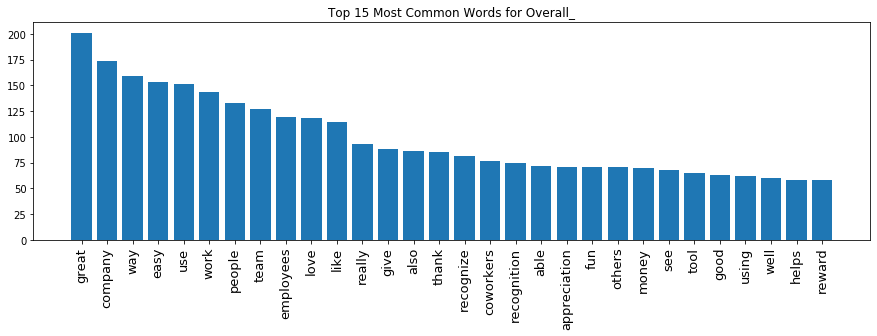

In [17]:
plot_most_common('Overall_')

#### Feedback

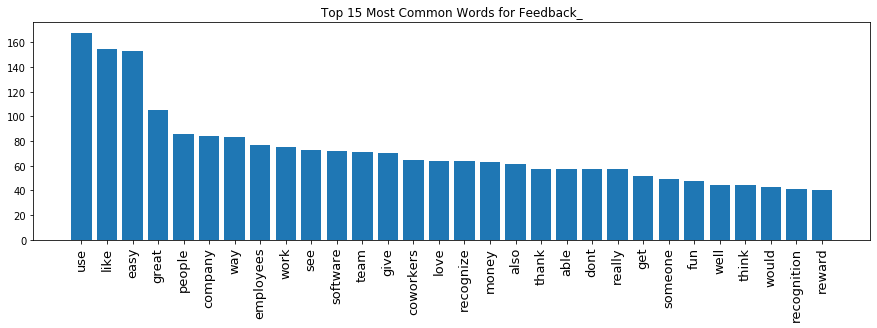

In [18]:
plot_most_common('Feedback_')

#### Cons

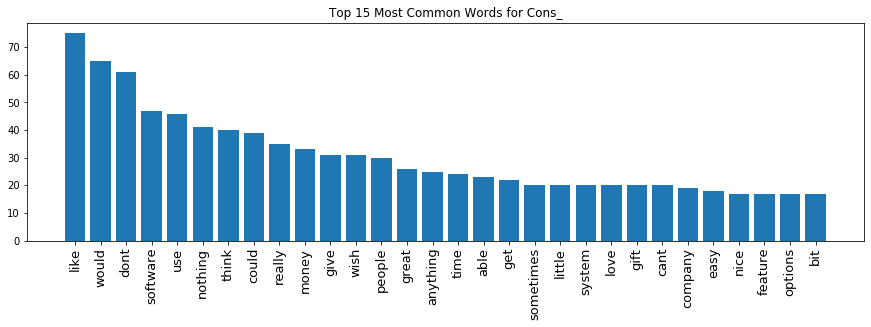

In [19]:
plot_most_common('Cons_')

## Using Word Charts to get a feel for the relative frequency of each word from the reviews


In [20]:
# function to make a word diagram for each of the columns
def make_word_diagram(text_field):
    text = " ".join(row for row in text_field)
    
    print(f"Total Words: {len(text)}")
    
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopWords, background_color="white").generate(text)
    
    # Display the generated image:
    plt.figure(figsize=[30,15])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    return  

### Word chart for all text from Overall, Feedback, and Cons

(626, 26)
Total Words: 253996


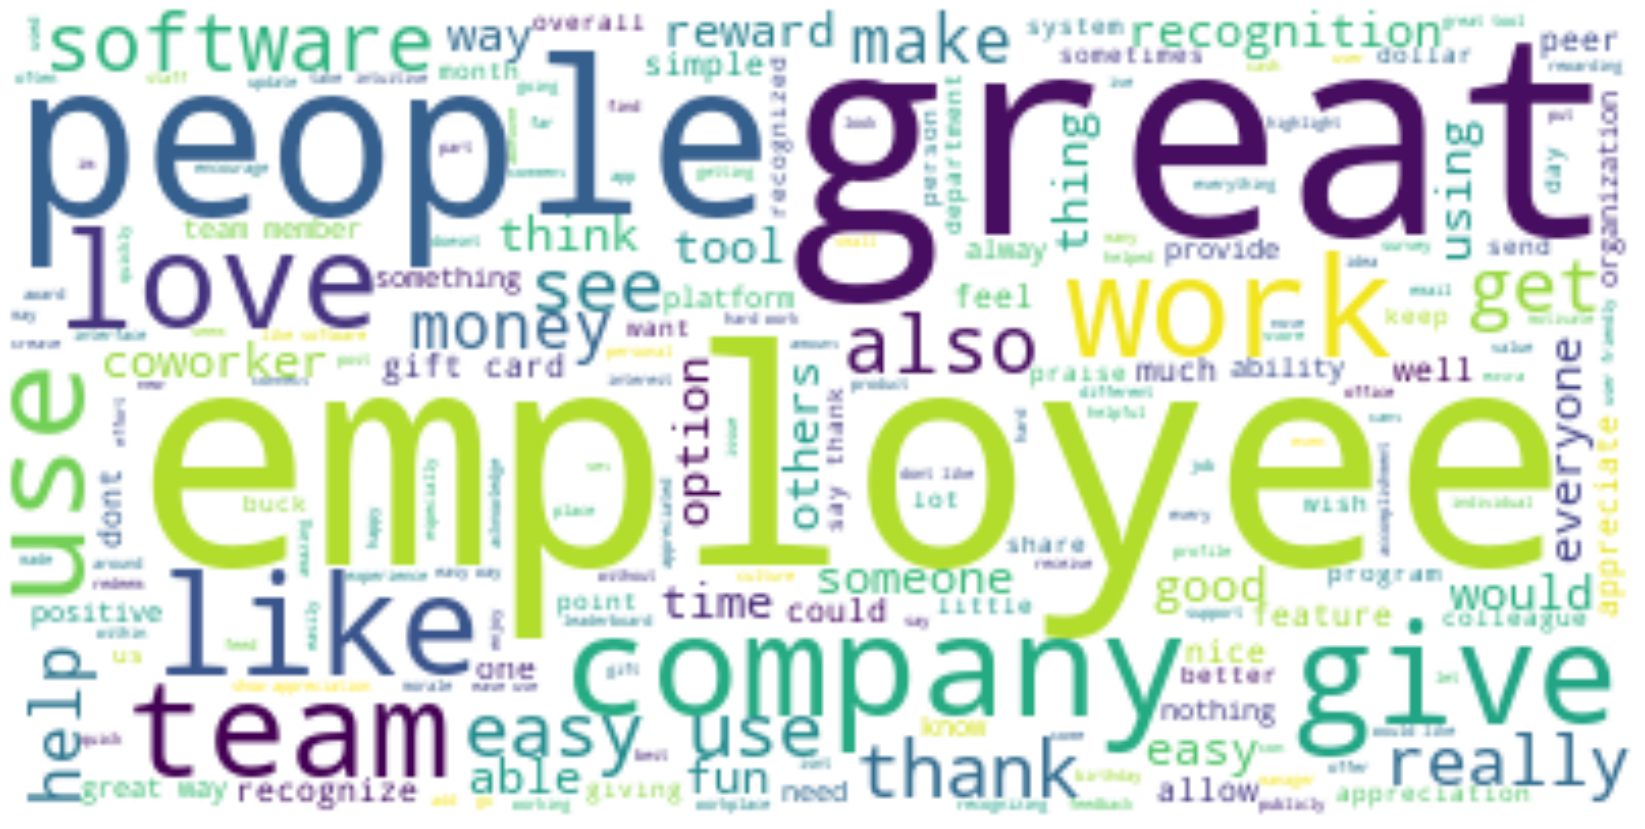

In [21]:
# combined 
temp_df = df#[]

print(temp_df.shape)
make_word_diagram(temp_df['Combined_'])

### Word chart for all text from Overall

(626, 26)
Total Words: 120927


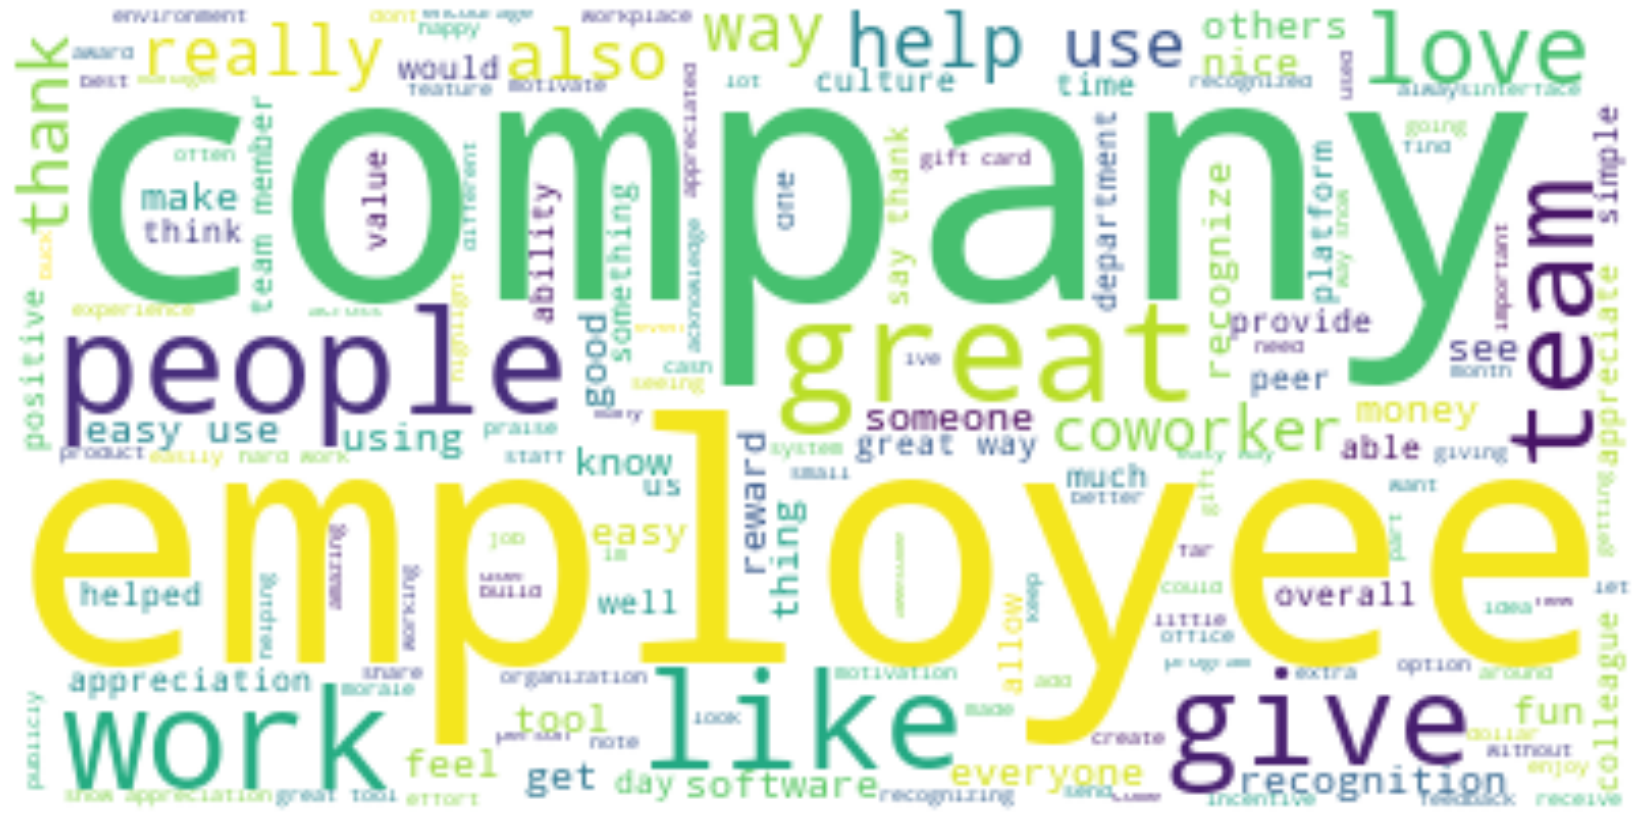

In [22]:
# add a filter based on overall rating
temp_df = df#[]

print(temp_df.shape)
make_word_diagram(temp_df['Overall_'])

### Word chart for all text from Feedback

(626, 26)
Total Words: 89888


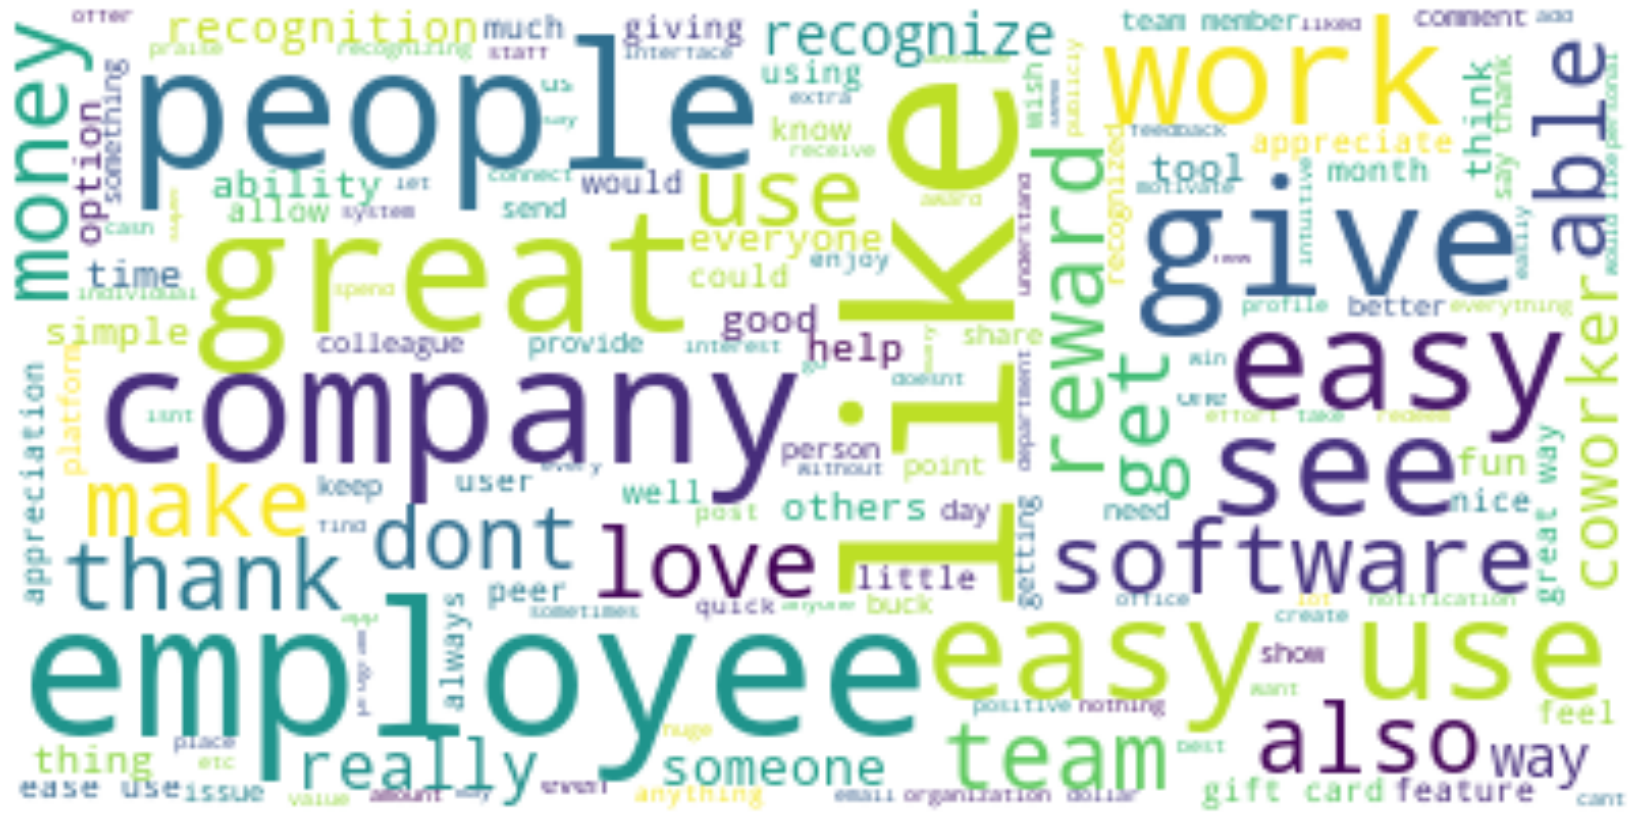

In [23]:
temp_df = df[
    (df['Feedback_'] != 'nan')
]
print(temp_df.shape)
make_word_diagram(temp_df['Feedback_'])

### Word chart for all text from Cons

(626, 26)
Total Words: 43179


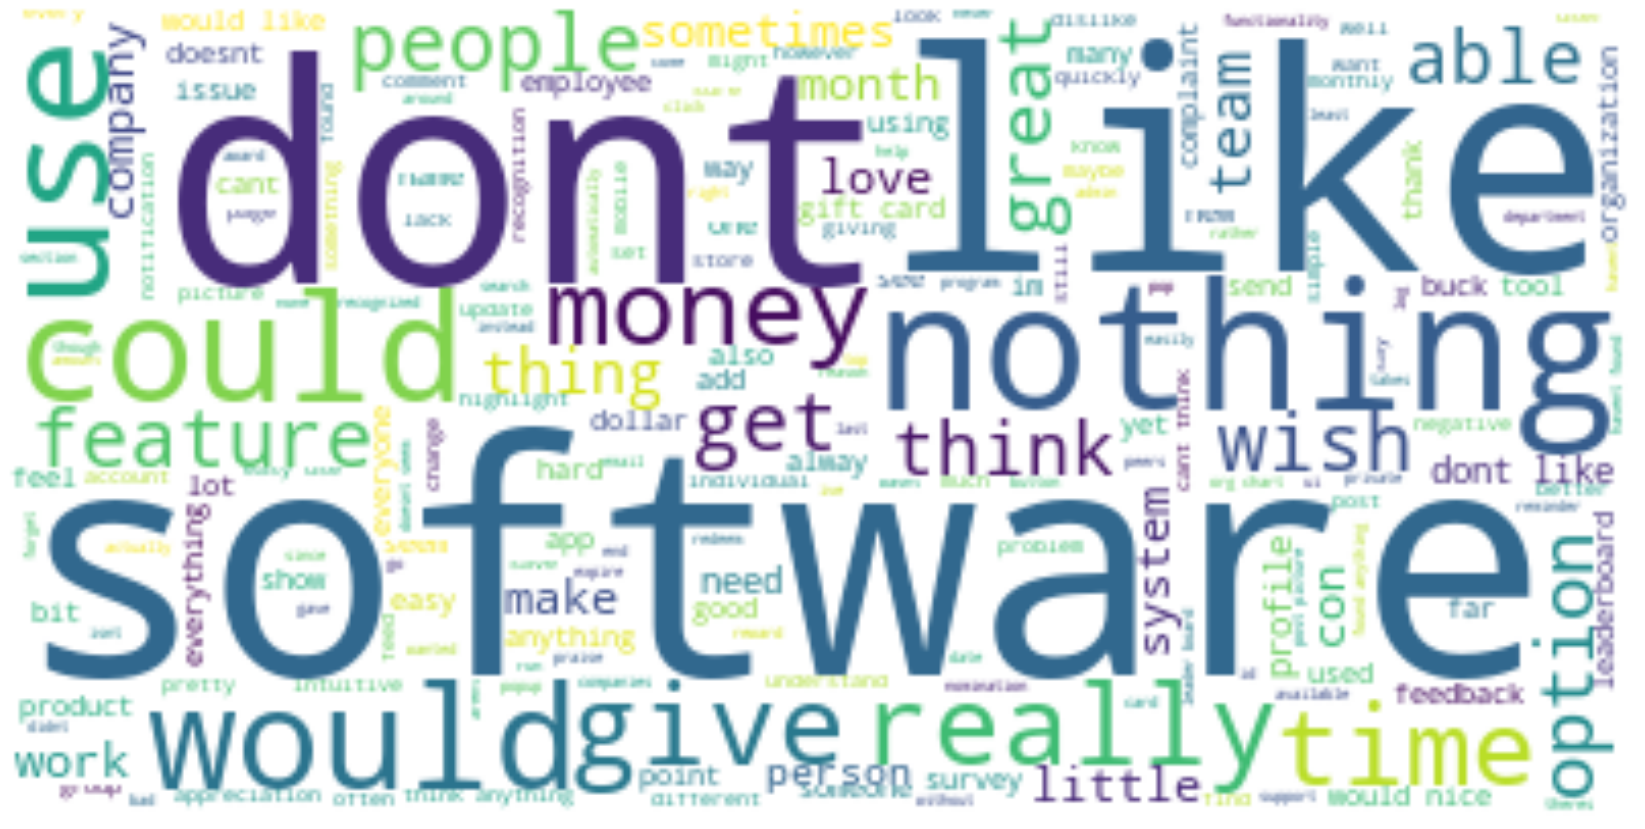

In [24]:
temp_df = df#[]

print(temp_df.shape)
make_word_diagram(df['Cons_'])

Total Words: 8842


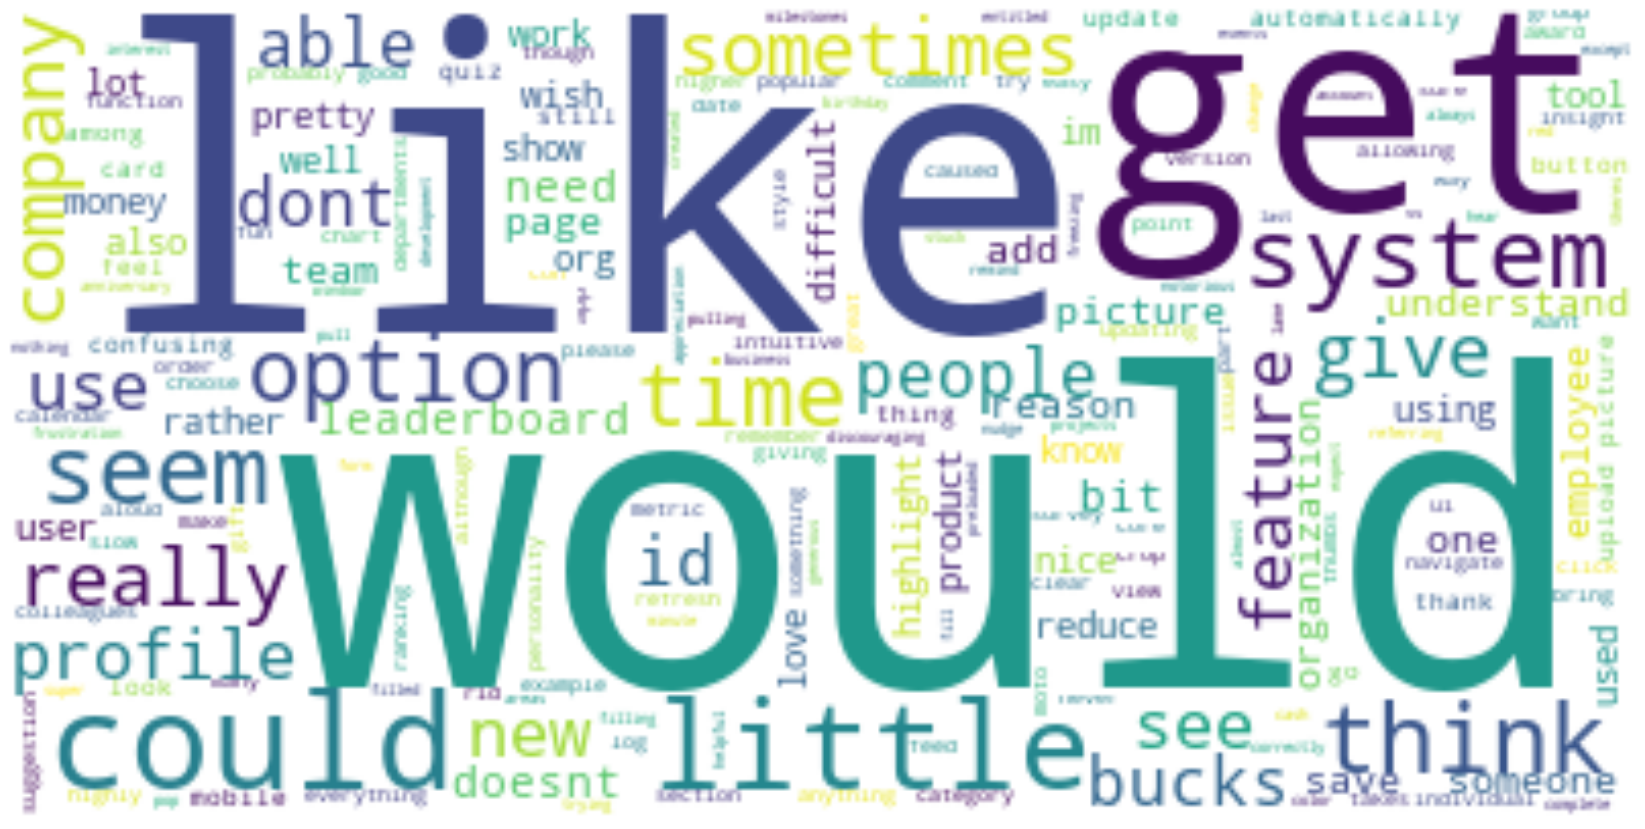

In [25]:
# focus in on non 5 star reviews
temp_df = df[
    (df['Rating_'] != 5)
]
make_word_diagram(temp_df['Cons_'])

### Scatter Plots of Polarity, Ratings, and Review Length

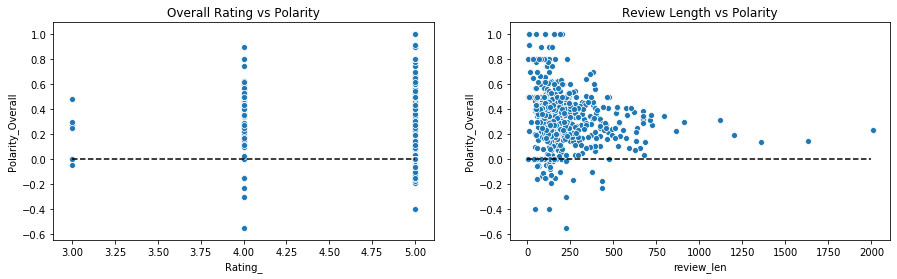

In [26]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.scatterplot(x = 'Rating_', y = 'Polarity_Overall', data = df)
plt.title("Overall Rating vs Polarity")
plt.hlines(y=0, xmin=3, xmax=5, linestyles='--')

plt.subplot(1,2,2)
sns.scatterplot(x = 'review_len', y = 'Polarity_Overall', data = df)
plt.title("Review Length vs Polarity")
plt.hlines(y=0, xmin=0, xmax=2000, linestyles='--')
plt.show()

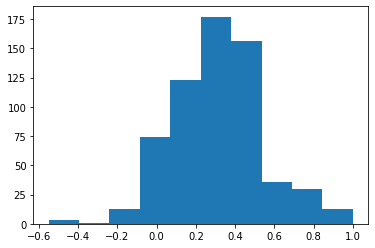

In [27]:
# distribution of overall polarity
plt.hist(df['Polarity_Overall'])
plt.show()

### End of Notebook